In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade openai pillow opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.81.0
    Uninstalling openai-1.81.0:
      Successfully uninstalled openai-1.81.0


In [ ]:
import cv2, base64, os, re, textwrap, matplotlib.pyplot as plt
from collections import OrderedDict
from openai import OpenAI
from pathlib import Path
from collections import defaultdict
import re, numpy as np, matplotlib.pyplot as plt

client = OpenAI(
  api_key=""
)

video_path = "/content/drive/MyDrive/CS_project/pumunk_videos/594_1748124142.mp4"

In [ ]:
# ───────────────────────────────────────────────────────────────
# 1. Sample one frame every 0.5 s (cap at 60 to keep tokens low)
# ───────────────────────────────────────────────────────────────
def sample_frames(path, step_s=0.5, cap_frames=60):
    cap  = cv2.VideoCapture(path)
    fps  = cap.get(cv2.CAP_PROP_FPS) or 25
    step = int(round(fps * step_s))
    imgs = []
    i    = 0
    while len(imgs) < cap_frames and cap.isOpened():
        ok, frame = cap.read()
        if not ok: break
        if i % step == 0:
            _, buf = cv2.imencode(".jpg", frame)
            b64 = base64.b64encode(buf).decode()
            imgs.append({"type": "image_url",
                         "image_url": {"url": f"data:image/jpeg;base64,{b64}"}})
        i += 1
    cap.release()
    return imgs

frames = sample_frames(video_path)

# ───────────────────────────────────────────────────────────────
# 2. Metrics & helper to extract the number from “Metric => 123”
# ───────────────────────────────────────────────────────────────
metrics = [
    "ball diameter in pixel",
    "original position of the ball at t=0 in pixel",
    "change of pixels of the ball moved between t=0 s and t=0.5 s",
    "change of pixels of the ball moved between t=0.5 and t=1 s",
    "Velocity t=0.5 s (pixel/s)",
    "Velocity t=1.0 s (pixel/s)",
    "Acceleration (pixel/s^2)",
    "assuming acceleration is 9.8 m/s^2 in real world, what is the diameter of the ball in reality (metres)",
]

In [ ]:
# num_re = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")   # float / int / sci

# def parse_number(text: str) -> float:
#     """Return first numeric literal after the first '=>'."""
#     seg = text.split("=>", 1)[-1]
#     m = num_re.search(seg)
#     if not m:
#         raise ValueError(f"No numeric literal found in: {text}")
#     return float(m.group(0))

num_re = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")

def parse_number(text: str) -> float:
    seg = text.split("=>", 1)[-1]          # look only after the arrow
    m = num_re.search(seg)
    return float(m.group(0)) if m else np.nan

one_shot_vals = defaultdict(list)   # {metric: [v1,…,v5]}
chain_vals    = defaultdict(list)

In [ ]:


# ───────────────────────────────────────────────────────────────
# 4-A. ONE-SHOT  (all questions in one user message)
# ───────────────────────────────────────────────────────────────
one_shot_messages = [
    {
        "role": "system",
        "content": (
            "You are an expert video analyst.\n"
            "Return a single line of comma-separated pairs like:\n"
            "Metric => number, Metric => number …\n"
            "No extra words. Pixel units unless the question says metres."
        ),
    },
    {   # supply all frames + bulk question
        "role": "user",
        "content": frames + [{
            "type": "text",
            "text": textwrap.dedent(
                "Answer the following *in this exact order*: \n• " +
                "\n• ".join(metrics) +
                "\n\nFormat: Metric => number, Metric => number, …"
            )
        }],
    },
]

# one_shot_resp = client.chat.completions.create(
#     model="gpt-4o",
#     messages=one_shot_messages,
#     max_tokens=120,
# )
# one_shot_text = one_shot_resp.choices[0].message.content
# print("ONE-SHOT RAW →", one_shot_text)

# # Parse
# one_shot_results = OrderedDict()
# for pair in one_shot_text.split(","):
#     if "=>" not in pair: continue
#     metric, valtxt = pair.split("=>", 1)
#     one_shot_results[metric.strip()] = parse_number("=>"+valtxt)


In [ ]:

# ───────────────────────────────────────────────────────────────
# 4-B. CHAIN  (ask questions sequentially)
# ───────────────────────────────────────────────────────────────
chain_messages = [
    {
        "role": "system",
        "content": (
            "You are an expert video analyst.\n"
            "For every reply output exactly: Metric => number\n"
            "No tuples, no extra words."
        ),
    },
    {"role": "user", "content": frames},      # send frames once
]

# chain_results = OrderedDict()

# for m in metrics:
#     chain_messages.append({"role": "user",
#                            "content": [{"type": "text", "text": m}]})
#     r = client.chat.completions.create(
#         model="gpt-4o",
#         messages=chain_messages,
#         max_tokens=20,
#     )
#     ans = r.choices[0].message
#     chain_messages.append(ans)
#     chain_results[m] = parse_number(ans.content)
#     print(ans.content)


In [ ]:
for run in range(1):
    # === ONE-SHOT =========================================================

    one_resp = client.chat.completions.create(
        model="gpt-4o",
        messages=one_shot_messages,
        max_tokens=120,
    ).choices[0].message.content

    for pair in one_resp.split(","):
        if "=>" not in pair: continue
        met, valtxt = pair.split("=>", 1)
        met = met.strip()
        if met in metrics:
            one_shot_vals[met].append(parse_number("=>"+valtxt))

    # === CHAIN ============================================================
    chain_results = OrderedDict()
    for met in metrics:
        chain_messages.append({"role": "user",
                               "content": [{"type": "text", "text": met}]})
        ans = client.chat.completions.create(
            model="gpt-4o",
            messages=chain_messages,
            max_tokens=20,
        ).choices[0].message
        chain_messages.append(ans)               # keep context
        chain_vals[met].append(parse_number(ans.content))

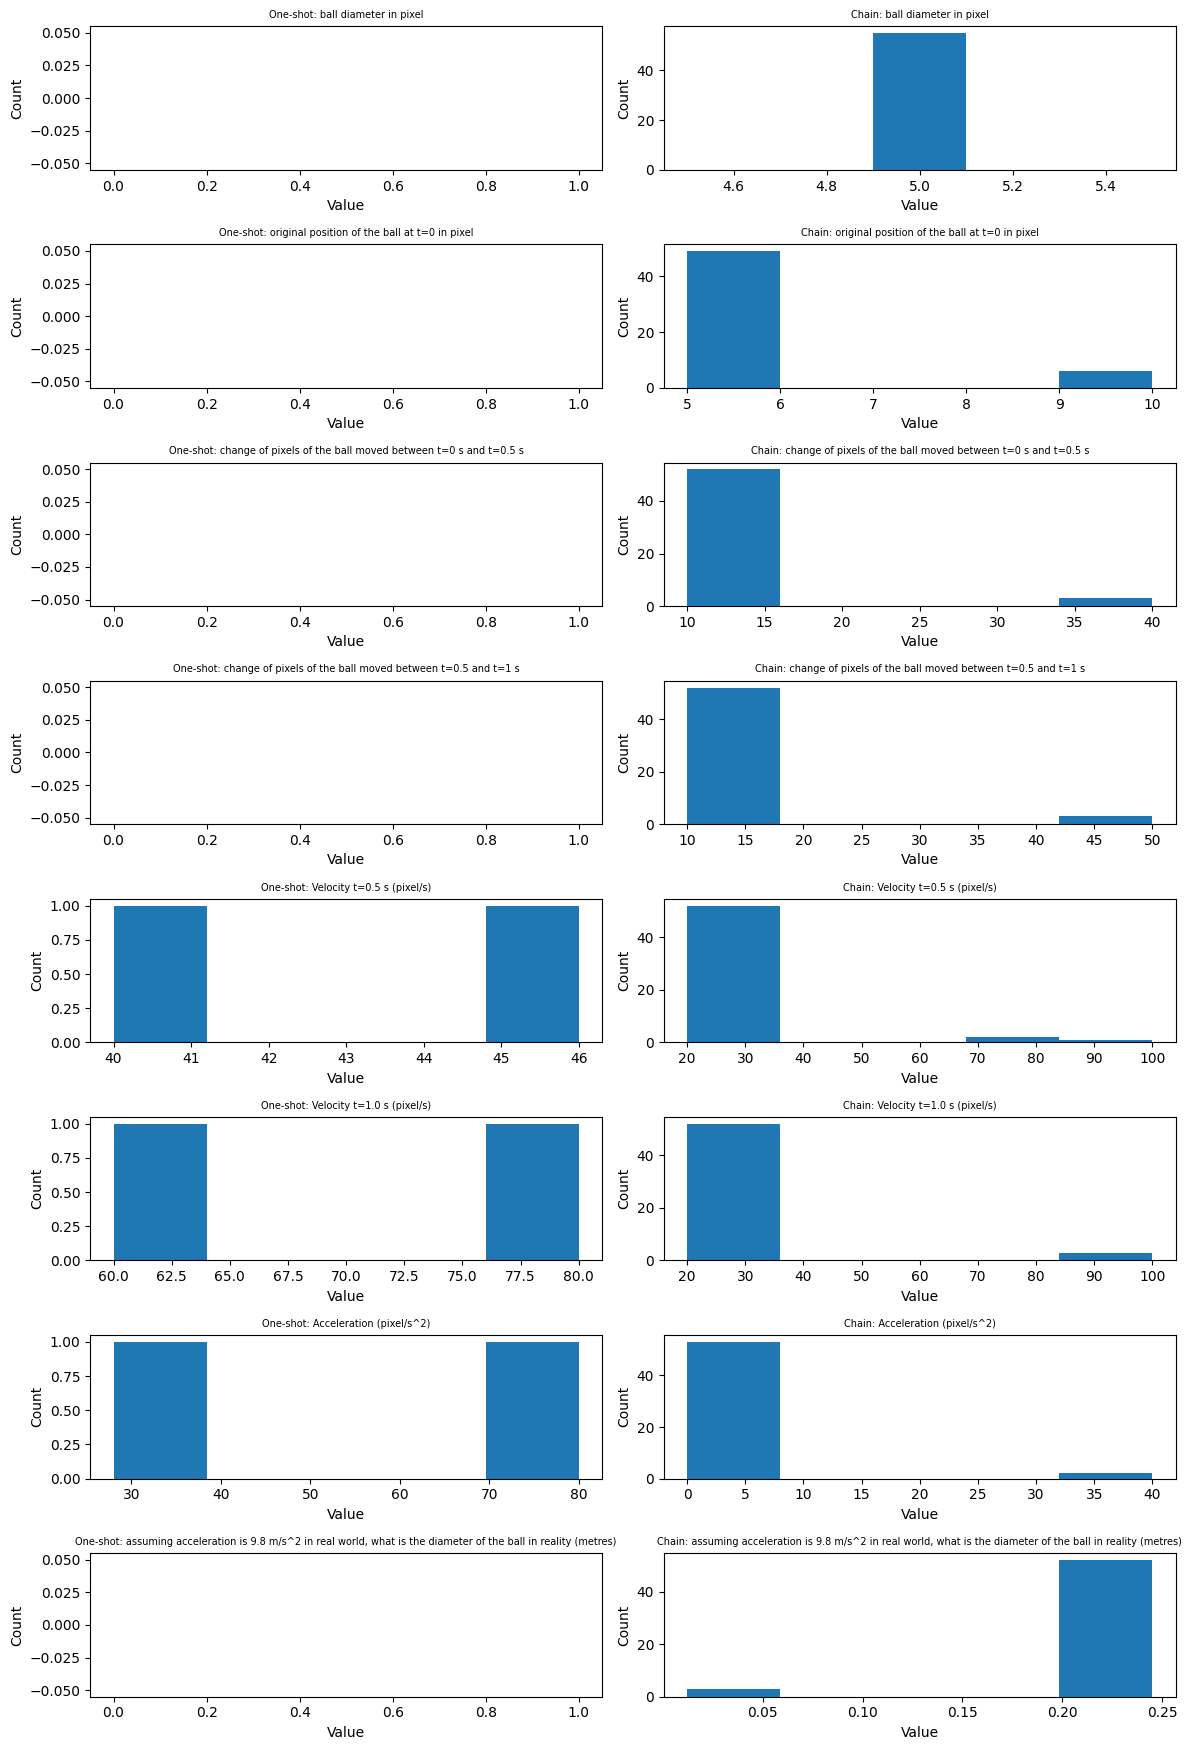

In [ ]:
fig, axs = plt.subplots(len(metrics), 2, figsize=(12, len(metrics)*2.2))
axs = axs.ravel()

for i, met in enumerate(metrics):
    # one-shot
    clean_one = [v for v in one_shot_vals[met] if not np.isnan(v)]
    axs[2*i].hist(clean_one, bins=5)
    axs[2*i].set_title(f"One-shot: {met}", fontsize=7)
    # chain
    clean_chain = [v for v in chain_vals[met] if not np.isnan(v)]
    axs[2*i+1].hist(clean_chain, bins=5)
    axs[2*i+1].set_title(f"Chain: {met}", fontsize=7)
    for j in (2*i, 2*i+1):
        axs[j].set_ylabel("Count")
        axs[j].set_xlabel("Value")

plt.tight_layout()
plt.show()
